In [28]:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from typing import *
import re
from ast import literal_eval
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


In [4]:
def load_params():
    with open("iMessage_params.txt", "r") as f:
        return literal_eval(f.read())

class iMessage:
    def __init__(self, db_path: str):
        """
        Connect to iMessage Database.
        To access messages as pandas dataframe, use iMessage.messages 
        -------
        PARAMS
        -------
        1. db_path -> path of the iMessage Database
        """
        self.db_path = db_path
        self.__connect_to_db()
        self.__get_messages()
        
    def __connect_to_db(self):
        self.conn = sqlite3.connect(self.db_path)
        self.cur = self.conn.cursor()
        
    def table_properties(self) -> list:
        self.cur.execute(" select name from sqlite_master where type = 'table' ")
        return [x for x in self.cur.fetchall()]
    
    def __get_messages(self):
        messages = pd.read_sql_query('''select *, datetime(date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime")  as date_utc from message''', self.conn) 
        handles = pd.read_sql_query("select * from handle", self.conn)
        chat_message_joins = pd.read_sql_query("select * from chat_message_join", self.conn)
        
        #standardize cols---------
        messages['message_date'] = messages['date']
        messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
        messages['date'] = messages['timestamp'].apply(lambda x: x.date())
        messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
        messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))
        messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)
        handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)
        #---------------------------
        
        msg_hndl = pd.merge(messages[['text', 'handle_id', 'date','message_date' ,'timestamp', 'month','year','is_sent', 'message_id']],  handles[['handle_id', 'phone_number']], on ='handle_id', how='left')
    
        self.messages = pd.merge(msg_hndl, chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')
    
    def filter_cols(self, cols: list):
        for c in cols:
            assert c in self.messages.columns, f"{c} not in columns"
        self.messages = self.messages[cols]
    
    def filter_phone_numbers(self, phone_num: Union[list,str]):
        #-----------------------------------
        def clean_phone_number(phone_num):
            if phone_num[0] != "+":
                phone_num = f"+{phone_num}"
            return re.sub(r"[\-\.]", "", phone_num)
        #-----------------------------------
        if type(phone_num) is str:
            phone_num = [phone_num]
        phone_num = [clean_phone_number(num) for num in phone_num]
        self.messages = self.messages[self.messages.phone_number.isin(phone_num)].reset_index(drop=True)
        
    def messages_to_csv(self, save_path: str):
        self.messages.to_csv(save_path, index=False)
    
    def return_messages(self) -> pd.DataFrame:
        return self.messages
        
        

In [6]:
params = load_params()

db = iMessage(params["db_path"])


In [10]:
cols = ['date', 'phone_number', 'text', 'is_sent']

db.filter_cols(cols)
db.filter_phone_numbers(params["phone_number"])
db.messages = db.messages.drop("phone_number", axis=1) #hide for publishing on github


In [31]:
#save as csv to build NLG model
db.messages_to_csv("iMessage_sample.csv")

In [20]:
db.messages['date'].min(), db.messages['date'].max()

(datetime.date(2018, 11, 20), datetime.date(2020, 9, 15))

In [19]:
db.messages[70:80]

,date,text,is_sent
70,2018-11-20,Jk 12 year old caol Ila Pete moss smoked scotch**,1
71,2018-11-20,Spit some good game alright figure it out,0
72,2018-11-20,Figuring it out,1
73,2018-11-20,I hate you hahaha,0
74,2018-11-20,Im texting you on my laptop this is lit,1
75,2018-11-20,wow,1
76,2018-11-20,This is sick,1
77,2018-11-20,All macs do that u ain’t special,0
78,2018-11-20,We have a good platform to rewatch game of thr...,1
79,2018-11-20,That 4k retina display,1


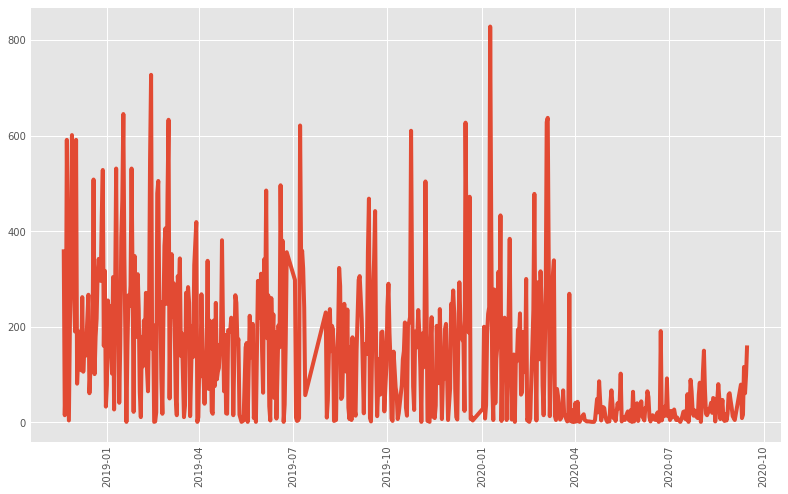

In [29]:
plt.figure(figsize=(12,8))
plt.plot(db.messages.groupby('date').size())
plt.xticks(rotation='90')
plt.show() #get rid of printed array
